In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2


In [3]:
def perform_eda(df):
    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    # Distribution of target variable
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Bankrupt?', data=df)
    plt.title('Distribution of Bankruptcy')
    plt.show()

    # Feature importance (using correlation with target)
    correlations = df.corr()['Bankrupt?'].sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=correlations.values[1:11], y=correlations.index[1:11])
    plt.title('Top 10 Features Correlated with Bankruptcy')
    plt.tight_layout()
    plt.show()

In [4]:
def evaluate_and_visualize(model, X_test, y_test, history=None):
    # Predictions
    y_pred = (model.predict(X_test) > 0.5).astype("int32") if history is not None else model.predict(X_test)

    # Classification report and confusion matrix
    print("\nModel Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nModel Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # ROC curve
    if history is not None:
        y_pred_proba = model.predict(X_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

        # Training history
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [5]:
def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    print("Basic information about the dataset:")
    print(df.info())

    # Feature and target split
    X = df.drop('Bankrupt?', axis=1)
    y = df['Bankrupt?']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Data normalization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Reshape data for 1D CNN
    X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
    X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

    return X_train_cnn, X_test_cnn, y_train, y_test, df, X_train_scaled, X_test_scaled

In [6]:
# Load the data
X_train_cnn, X_test_cnn, y_train, y_test, df, X_train_scaled, X_test_scaled = load_and_prepare_data('data.csv')

Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-n

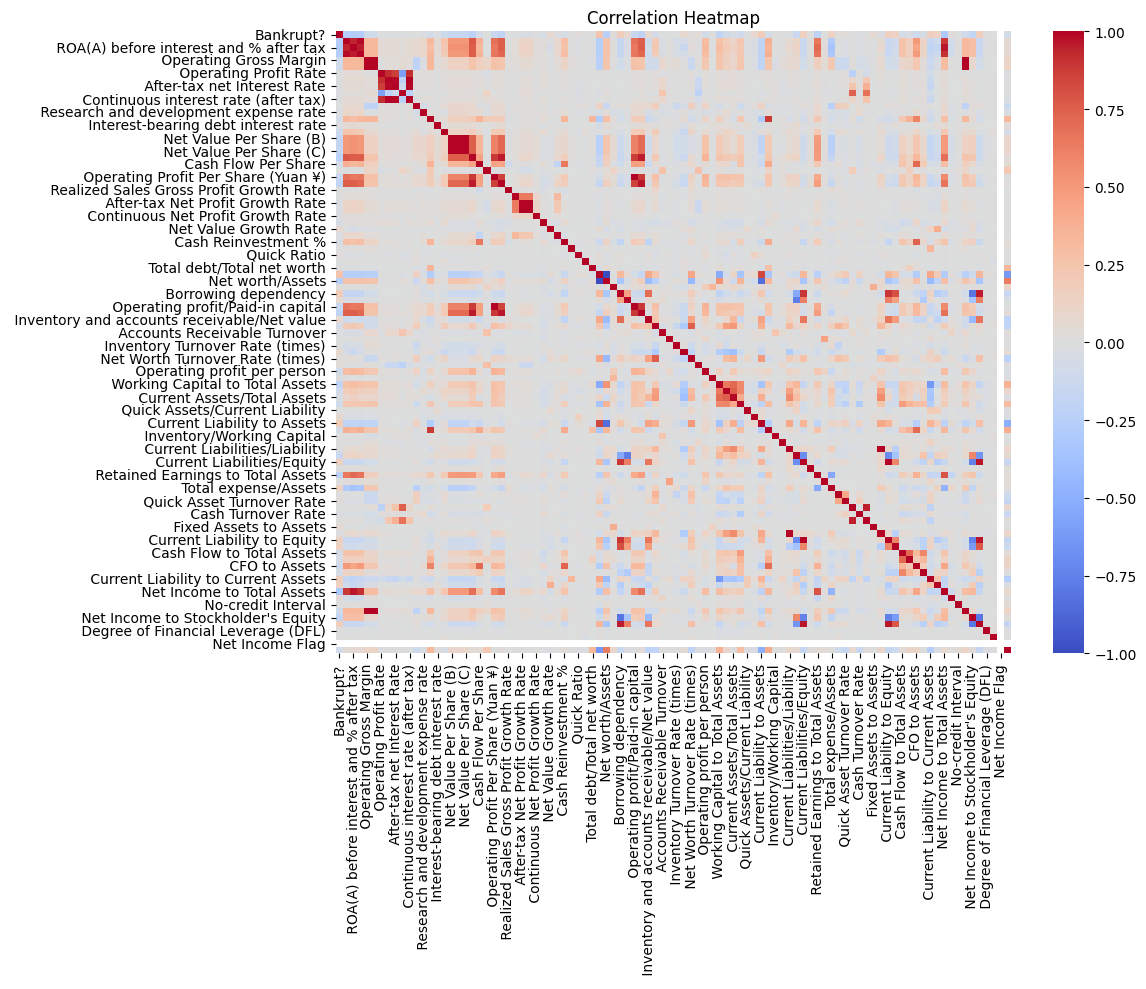

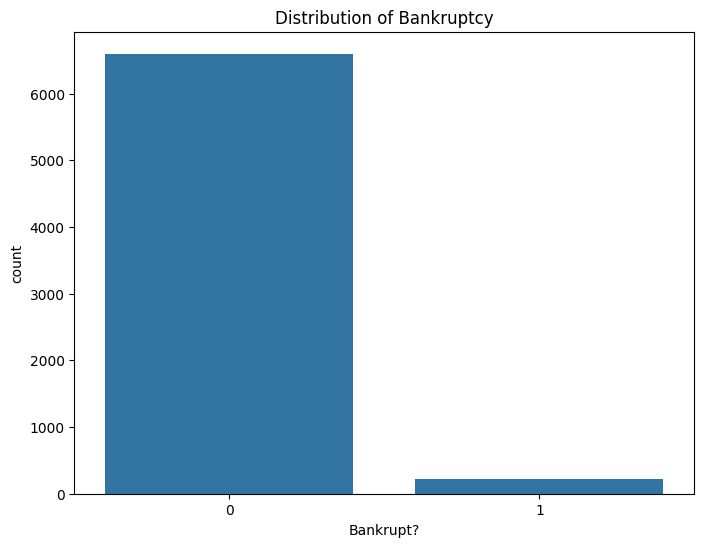

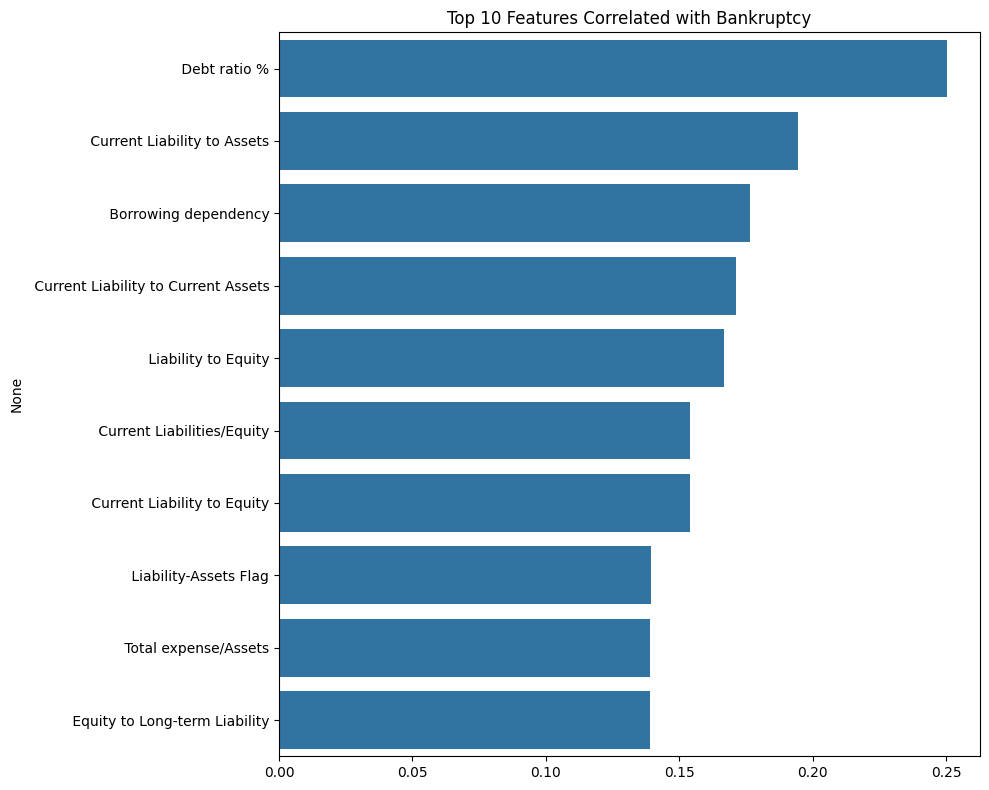

In [7]:
perform_eda(df)

In [8]:
# Applying SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set shape: {X_train_scaled.shape}, {y_train.value_counts()}")
print(f"Balanced training set shape: {X_train_balanced.shape}, {y_train_balanced.value_counts()}")

Original training set shape: (5455, 95), Bankrupt?
0    5286
1     169
Name: count, dtype: int64
Balanced training set shape: (10572, 95), Bankrupt?
0    5286
1    5286
Name: count, dtype: int64


In [9]:
def create_1d_cnn_model(input_shape):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

In [10]:
# Create the CNN model
cnn_model = create_1d_cnn_model((X_train_cnn.shape[1], 1))
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 93, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 93, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 46, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 46, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 44, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 44, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 22, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 22, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 20, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 20, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2560)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         327,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │              

 Total params: 462,209 (1.76 MB)

 Trainable params: 460,929 (1.76 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [11]:
def train_model(model, X_train, y_train, X_test, y_test):
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

    history = model.fit(
        X_train, y_train,
        epochs=150,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f'1D CNN Test Accuracy: {test_accuracy:.4f}')

    return model, history

In [12]:
# Train the CNN model
trained_cnn, cnn_history = train_model(cnn_model, X_train_cnn, y_train_balanced, X_test_cnn, y_test)

Epoch 1/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.6421 - loss: 6.1056 - val_accuracy: 0.9652 - val_loss: 3.9158 - learning_rate: 0.0010
Epoch 2/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9146 - loss: 3.4239 - val_accuracy: 0.9661 - val_loss: 2.0410 - learning_rate: 0.0010
Epoch 3/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9551 - loss: 1.8170 - val_accuracy: 0.9643 - val_loss: 1.1552 - learning_rate: 0.0010
Epoch 4/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9592 - loss: 1.0444 - val_accuracy: 0.9661 - val_loss: 0.7480 - learning_rate: 0.0010
Epoch 5/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9595 - loss: 0.6899 - val_accuracy: 0.9661 - val_loss: 0.5289 - learning_rate: 0.0010
Epoch 6/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9599 - loss: 0.5086 - val_accuracy: 0.9661 - val_loss: 0.4392 - learning_rate: 0.0010
Epoch 7/150
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9685 - loss: 

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1313
           1       0.45      0.25      0.33        51

    accuracy                           0.96      1364
   macro avg       0.71      0.62      0.65      1364
weighted avg       0.95      0.96      0.96      1364


Model Confusion Matrix:
[[1297   16]
 [  38   13]]
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


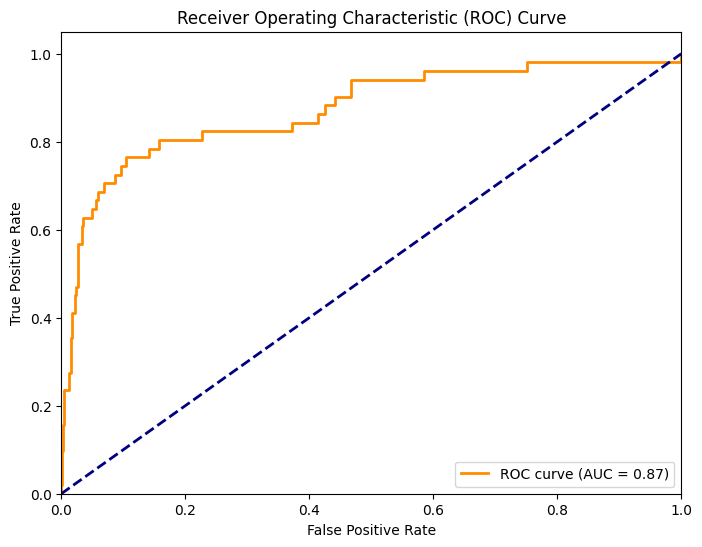

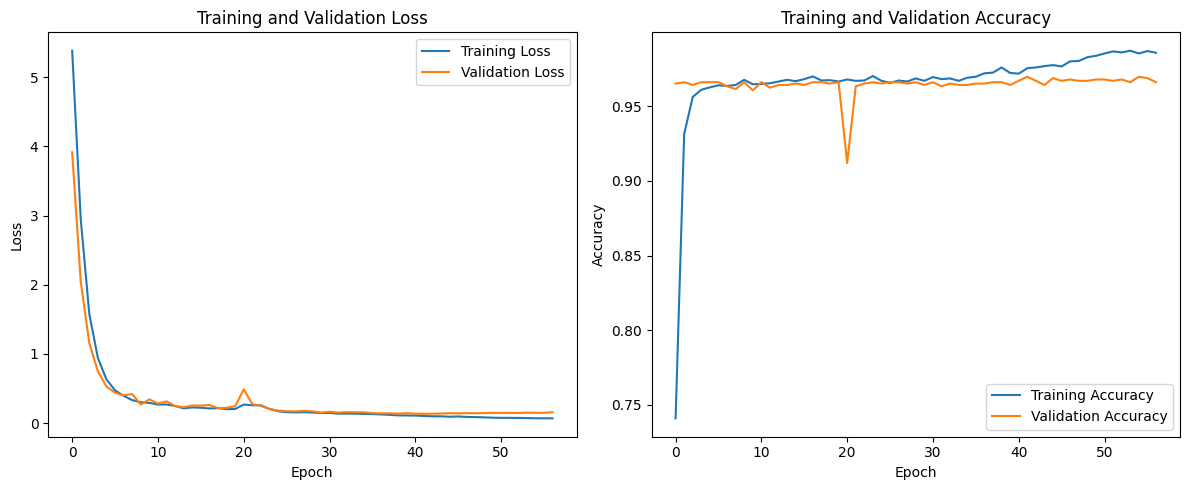

In [13]:
evaluate_and_visualize(trained_cnn, X_test_cnn, y_test, cnn_history)

In [14]:
def train_random_forest(X_train, y_train, X_test, y_test):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    print("\nRandom Forest Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nRandom Forest Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return rf_model

In [15]:
# Train the Random Forest model
rf_model = train_random_forest(X_train_balanced, y_train_balanced, X_test_scaled, y_test)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1313
           1       0.44      0.55      0.49        51

    accuracy                           0.96      1364
   macro avg       0.71      0.76      0.73      1364
weighted avg       0.96      0.96      0.96      1364


Random Forest Confusion Matrix:
[[1277   36]
 [  23   28]]


In [16]:
def compare_models(cnn_history, rf_model, X_test, y_test):
    # CNN model evaluation
    y_pred_cnn = (trained_cnn.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1))) > 0.5).astype("int32")
    print("\nCNN Model Classification Report:")
    print(classification_report(y_test, y_pred_cnn))

    # Random Forest model evaluation
    y_pred_rf = rf_model.predict(X_test)

    # Confusion Matrices
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Blues')
    plt.title('CNN Confusion Matrix')

    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
    plt.title('Random Forest Confusion Matrix')

    plt.tight_layout()
    plt.show()

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

CNN Model Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1313
           1       0.45      0.25      0.33        51

    accuracy                           0.96      1364
   macro avg       0.71      0.62      0.65      1364
weighted avg       0.95      0.96      0.96      1364



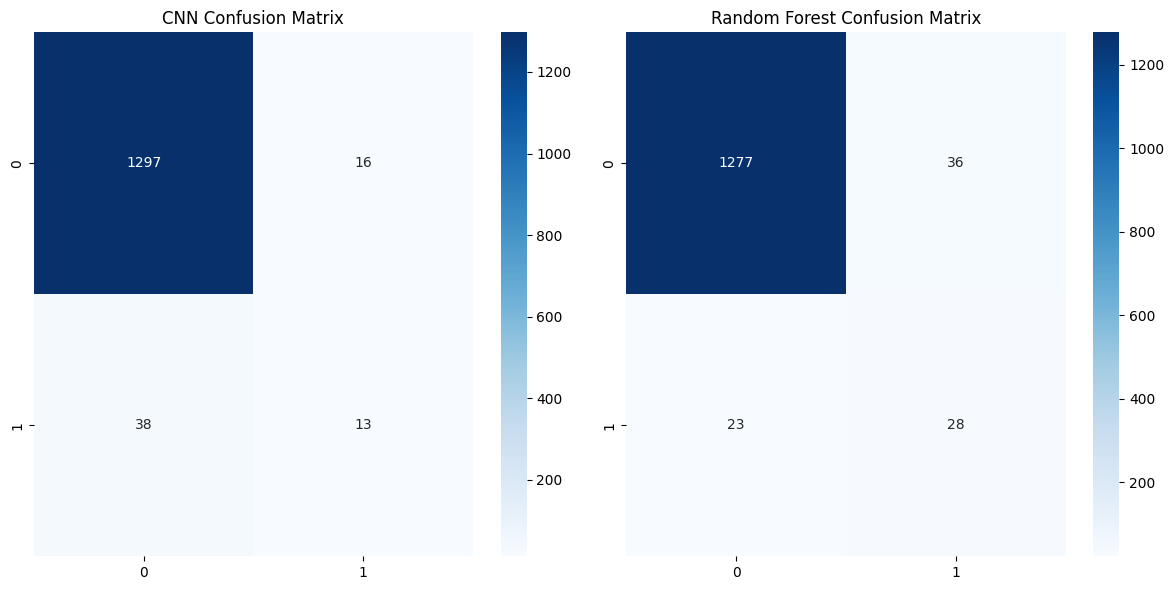

In [17]:
# Compare models
compare_models(cnn_history, rf_model, X_test_scaled, y_test)